In [1]:
from prometheus_api_client import *
import prometheus_api_client
from prometheus_api_client.utils import parse_datetime, parse_timedelta
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import datetime
import pandas as pd
# import seaborn as sns
# # Set default Seaborn style
# sns.set(style="darkgrid")
# sns.set_context("talk", font_scale=1.4)
## hides ipython warnings
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (30, 10)
#plt.rcParams['figure.figsize'] = (20, 5)

In [4]:
sample_df = pd.read_csv('sample_cluster_15d_15_min_int.csv',index_col='timestamp')

In [5]:
sample_df.head()

,Cpu_usage,Memory_usage(bytes),api_server_requests,api_server_requests_lt
timestamp,,,,
2022-05-24 06:10:09,10.851524,7.902974e+10,29,3.367296
2022-05-24 06:25:09,10.313238,7.976337e+10,37,3.610918
2022-05-24 06:40:09,10.851333,7.848636e+10,19,2.944439
2022-05-24 06:55:09,10.411907,8.006373e+10,30,3.401197
2022-05-24 07:10:09,10.873429,7.883173e+10,21,3.044522


In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler()

In [10]:
scaler.fit(sample_df['Memory_usage(bytes)'].values.reshape(-1,1))

StandardScaler()

In [12]:
sample_df['Memory_usage(bytes)'] = scaler.transform(sample_df['Memory_usage(bytes)'].values.reshape(-1,1))

In [13]:
sample_df.head()

,Cpu_usage,Memory_usage(bytes),api_server_requests,api_server_requests_lt
timestamp,,,,
2022-05-24 06:10:09,10.851524,0.847365,29,3.367296
2022-05-24 06:25:09,10.313238,1.160429,37,3.610918
2022-05-24 06:40:09,10.851333,0.615487,19,2.944439
2022-05-24 06:55:09,10.411907,1.288604,30,3.401197
2022-05-24 07:10:09,10.873429,0.762870,21,3.044522


In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')
    p_value = round(res[1],3)
    if p_value <= sig:
        print(f'{name} has p-value: {p_value}. It is stationary')
    else:
        print(f'{name} has p-value: {p_value}. It is non-stationary')

In [16]:
for name, column in sample_df.iteritems():
    #print(name,column)
    adfuller_test(column,name=name)

Cpu_usage has p-value: 0.66. It is non-stationary
Memory_usage(bytes) has p-value: 0.066. It is non-stationary
api_server_requests has p-value: 0.0. It is stationary
api_server_requests_lt has p-value: 0.0. It is stationary


In [17]:
sample_df_differenced = sample_df.diff().dropna()

In [83]:
sample_df_differenced.shape

(1484, 4)

In [106]:
sample_df_differenced.drop(columns=['api_server_requests'],inplace=True)

In [22]:
import statsmodels.api as sm

In [26]:
sample_df.index

Index(['2022-05-24 06:10:09', '2022-05-24 06:25:09', '2022-05-24 06:40:09',
       '2022-05-24 06:55:09', '2022-05-24 07:10:09', '2022-05-24 07:25:09',
       '2022-05-24 07:40:09', '2022-05-24 07:55:09', '2022-05-24 08:10:09',
       '2022-05-24 08:25:09',
       ...
       '2022-06-08 14:55:09', '2022-06-08 15:10:09', '2022-06-08 15:25:09',
       '2022-06-08 15:40:09', '2022-06-08 15:55:09', '2022-06-08 16:10:09',
       '2022-06-08 16:25:09', '2022-06-08 16:40:09', '2022-06-08 16:55:09',
       '2022-06-08 17:10:09'],
      dtype='object', name='timestamp', length=1485)

In [107]:
length = len(sample_df_differenced)

In [108]:
split_ratio = 0.85
int(length*split_ratio)

1261

In [109]:
df_train = sample_df_differenced[:int(length*split_ratio)]
df_test = sample_df_differenced[int(length*split_ratio):]

In [110]:
from statsmodels.tsa.api import VAR

In [126]:
df_train.shape

(1261, 3)

In [127]:
model = VAR(df_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


In [112]:
for i in range(1,10):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -6.275183674925329
BIC :  -6.226242084449657
FPE :  0.0018824453844847743
HQIC:  -6.256792168634302 

Lag Order = 2
AIC :  -6.395303087936481
BIC :  -6.309600519457585
FPE :  0.001669380391961887
HQIC:  -6.363096098275596 

Lag Order = 3
AIC :  -6.514577875476119
BIC :  -6.392067260915061
FPE :  0.0014816827099950456
HQIC:  -6.4685366259164105 

Lag Order = 4
AIC :  -6.552834806590932
BIC :  -6.393468979116771
FPE :  0.0014260703932228818
HQIC:  -6.492940480130239 

Lag Order = 5
AIC :  -6.59726026394014
BIC :  -6.400991957684288
FPE :  0.001364105837554179
HQIC:  -6.52349400298415 

Lag Order = 6
AIC :  -6.623511825499913
BIC :  -6.3902936752694295
FPE :  0.0013287656046195948
HQIC:  -6.535854731742768 

Lag Order = 7
AIC :  -6.628769154955321
BIC :  -6.3585536959451705
FPE :  0.001321803280066201
HQIC:  -6.527202289259783 

Lag Order = 8
AIC :  -6.668528638221862
BIC :  -6.361268305726088
FPE :  0.0012702865817129615
HQIC:  -6.553033020499022 

Lag Order = 9
AIC 

In [128]:
x = model.select_order(maxlags=12)

In [129]:
x.summary()

,AIC,BIC,FPE,HQIC
0,-5.120,-5.107,0.005978,-5.115
1,-6.265,-6.215,0.001903,-6.246
2,-6.384,-6.298,0.001689,-6.351
3,-6.503,-6.380,0.001499,-6.457
4,-6.542,-6.382,0.001442,-6.482
5,-6.587,-6.390*,0.001378,-6.513
6,-6.616,-6.382,0.001339,-6.528
7,-6.623,-6.351,0.001330,-6.521
8,-6.662,-6.354,0.001279,-6.546
9,-6.676,-6.331,0.001261,-6.547


In [130]:
model_fitted = model.fit(5)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 08, Jun, 2022
Time:                     18:26:53
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -6.40099
Nobs:                     1256.00    HQIC:                  -6.52349
Log likelihood:          -1155.48    FPE:                 0.00136411
AIC:                     -6.59726    Det(Omega_mle):      0.00131327
--------------------------------------------------------------------
Results for equation Cpu_usage
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            -0.007659         0.010390           -0.737           0.461
L1.Cpu_usage                     -0.549105         0.028481          -19.279           0.000
L1.Memor

In [48]:
from statsmodels.stats.stattools import durbin_watson

Checking the serial Correlation of the residuals

In [116]:
out = durbin_watson(model_fitted.resid)

In [117]:
for col,val in zip(df_train.columns,out):
    print(col,':',round(val,2))

Cpu_usage : 2.03
Memory_usage(bytes) : 1.99
api_server_requests_lt : 2.03


In [118]:
model_fitted.k_ar

5

In [131]:
forecast_input = df_train.values[-5:]

In [132]:
forecast_input

array([[ 0.19842813, -0.65454185, -0.78845736],
       [-0.13714286,  0.27695947, -0.06899287],
       [ 0.10190476, -0.49641838,  0.19415601],
       [-0.07542857,  0.62650733,  0.        ],
       [ 0.12790476, -0.69786172,  0.25782911]])

In [133]:
output = model_fitted.forecast(y=forecast_input,steps=len(df_test))

In [134]:
output.shape

(223, 3)

In [136]:
df_forecast = pd.DataFrame(output,index=sample_df_differenced.index[int(length*split_ratio):],columns=sample_df_differenced.columns+'_1d')

These are one differenced values

In [103]:
sample_df_differenced.index[-int(length*split_ratio):],

(Index(['2022-05-26 14:10:09', '2022-05-26 14:25:09', '2022-05-26 14:40:09',
        '2022-05-26 14:55:09', '2022-05-26 15:10:09', '2022-05-26 15:25:09',
        '2022-05-26 15:40:09', '2022-05-26 15:55:09', '2022-05-26 16:10:09',
        '2022-05-26 16:25:09',
        ...
        '2022-06-08 14:55:09', '2022-06-08 15:10:09', '2022-06-08 15:25:09',
        '2022-06-08 15:40:09', '2022-06-08 15:55:09', '2022-06-08 16:10:09',
        '2022-06-08 16:25:09', '2022-06-08 16:40:09', '2022-06-08 16:55:09',
        '2022-06-08 17:10:09'],
       dtype='object', name='timestamp', length=1261),)

In [137]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [138]:
df_results = invert_transformation(df_train,df_forecast)

In [139]:
df_results

,Cpu_usage_1d,Memory_usage(bytes)_1d,api_server_requests_lt_1d,Cpu_usage_forecast,Memory_usage(bytes)_forecast,api_server_requests_lt_forecast
timestamp,,,,,,
2022-06-06 09:40:09,-0.227946,0.465972,-0.123740,-0.100041,-0.231890,0.134090
2022-06-06 09:55:09,0.054534,-0.312574,-0.082391,-0.045507,-0.544464,0.051699
2022-06-06 10:10:09,0.010969,0.199952,-0.005869,-0.034539,-0.344512,0.045830
2022-06-06 10:25:09,0.019311,-0.131538,0.017183,-0.015228,-0.476051,0.063013
2022-06-06 10:40:09,-0.043638,0.067837,0.017030,-0.058866,-0.408213,0.080043
...,...,...,...,...,...,...
2022-06-08 16:10:09,-0.003645,-0.001190,-0.000180,-0.822827,-0.686338,0.041714
2022-06-08 16:25:09,-0.003645,-0.001190,-0.000180,-0.826472,-0.687529,0.041535
2022-06-08 16:40:09,-0.003645,-0.001190,-0.000180,-0.830117,-0.688719,0.041355


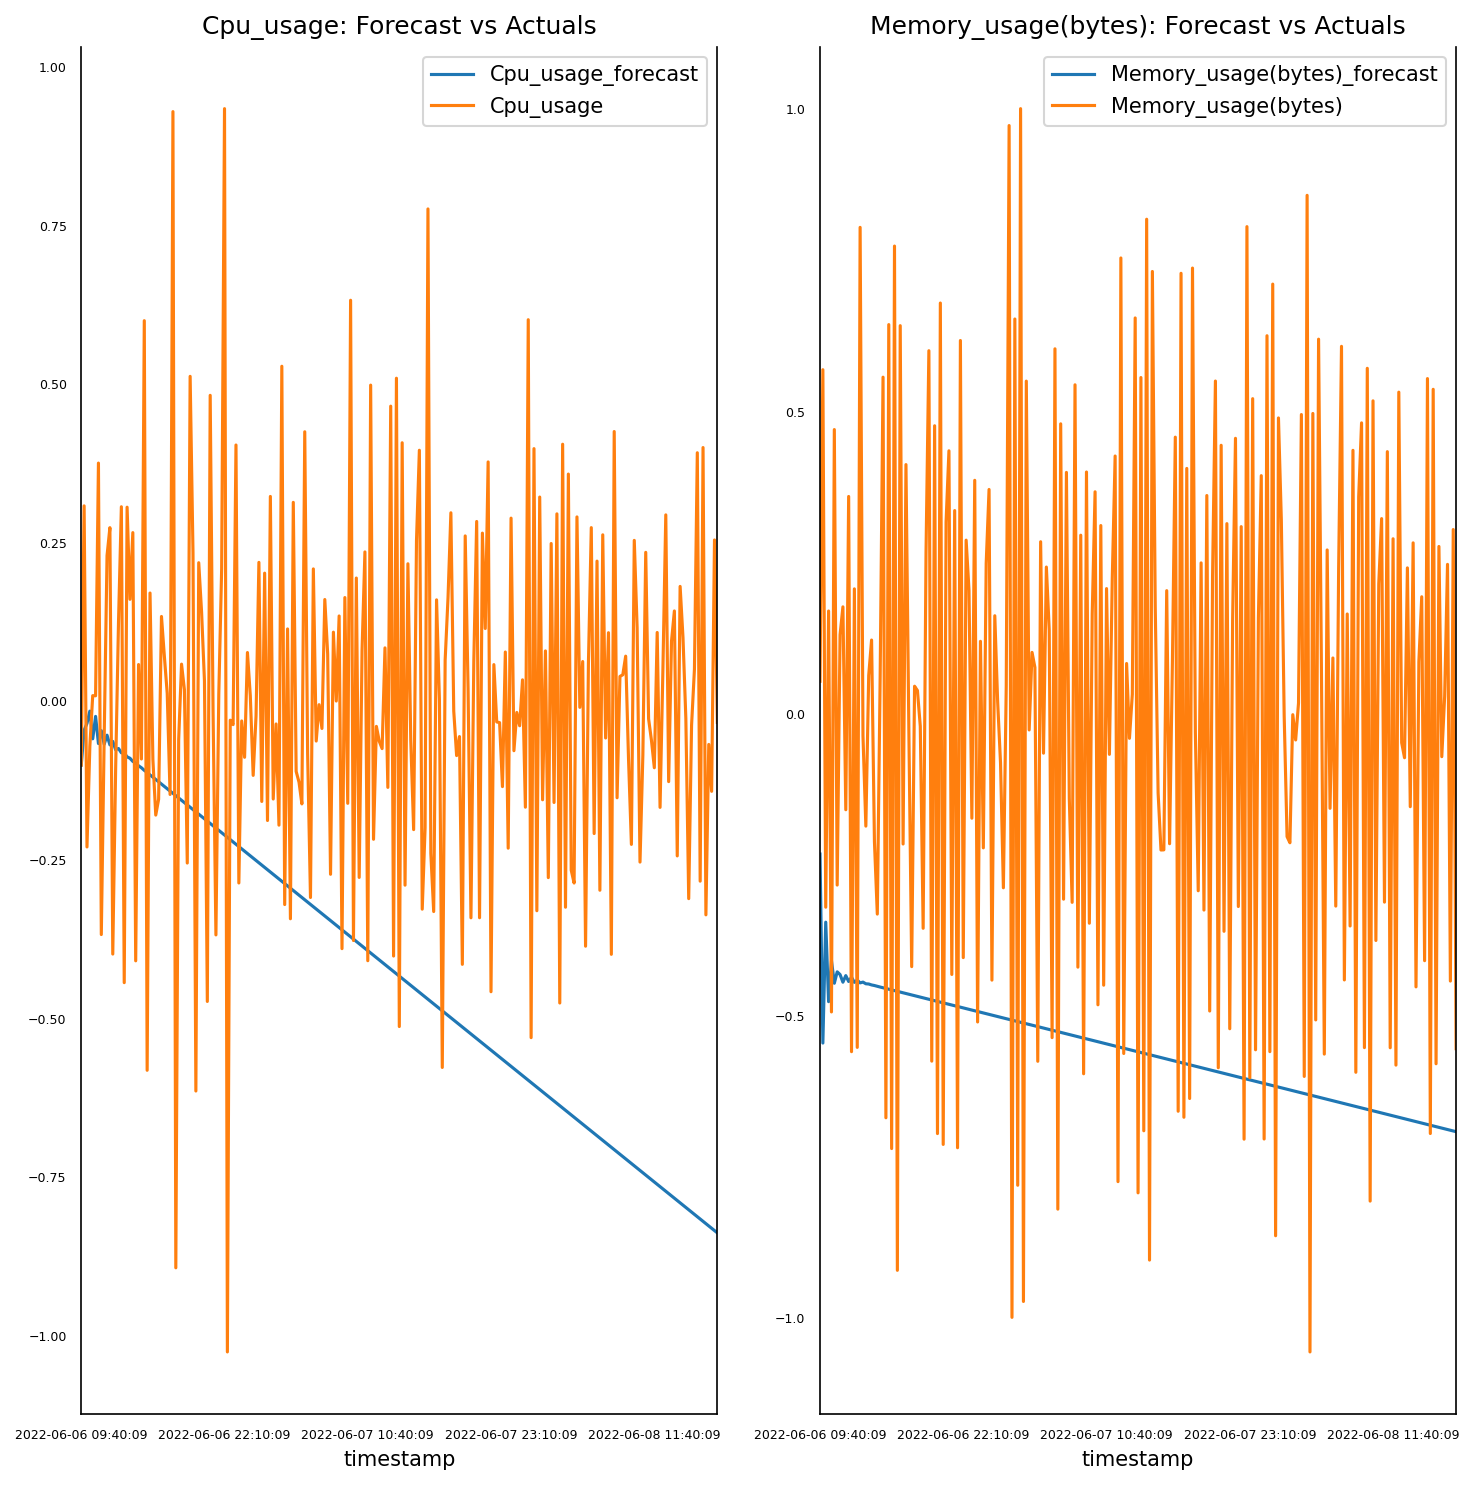

In [140]:
fig, axes = plt.subplots(nrows=int(len(sample_df_differenced.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(sample_df_differenced.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-int(length*split_ratio):].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()